<a href="https://colab.research.google.com/github/nrajmalwar/EVA-6-Phase-1/blob/main/Session_07/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The goal here is to achieve 85% accuracy on the cifar 10 dataset using

- Depthwise Separable Convolution
- Dilated Convolution
- Not using Max Pooling
- Augmentation
  - Horizontal Flip
  - ShiftScaleRotate
  - CoarseDropout


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



# Check GPU

In [1]:
!nvidia-smi

Fri Jun 18 17:57:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
!pip install --upgrade --force-reinstall --no-deps albumentations
!pip install torchsummary

  Using cached https://files.pythonhosted.org/packages/b0/be/3db3cd8af771988748f69eace42047d5edebf01eaa7e1293f3b3f75f989e/albumentations-1.0.0-py3-none-any.whl
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import make_grid
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

from model import Net

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")
print("Device = ", device)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True
Device =  cuda


# Loading Dataset

## Mean and Std Deviation of Data

In [5]:
# load the training data
train_data = datasets.CIFAR10('./cifar10_data', train=True, download=True)

# use np.concatenate to stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])
print("Shape of training data = ", x.shape)

# calculate the mean and std along the (0, 1) axes and divide by maximum pixel value of 255
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255

# print the mean and std
print("Mean = ", mean)
print("Std Deviation = ", std)

Files already downloaded and verified
Shape of training data =  (1600000, 32, 3)
Mean =  [0.49139968 0.48215841 0.44653091]
Std Deviation =  [0.24703223 0.24348513 0.26158784]


## Class to apply albumentations tranforms

In [6]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



## Data loaders

In [7]:
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1,
                        min_height=16, min_width=16,
                        fill_value=mean, mask_fill_value = None),
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)

trainset = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transform)

test_loader =torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



## Plot training images

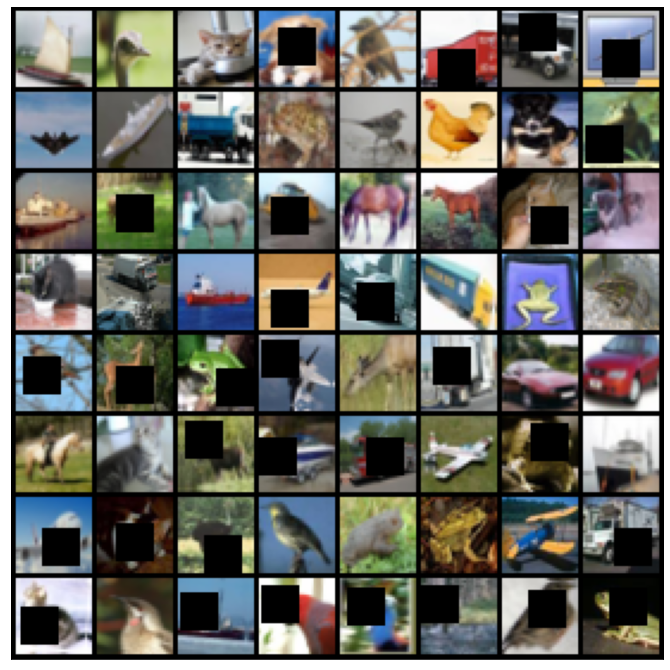

In [8]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, mean, std)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

show_batch(train_loader)

# Custom Model

In [9]:
net = Net()

model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
            Conv2d-2           [-1, 32, 32, 32]           4,608
       BatchNorm2d-3           [-1, 32, 32, 32]              64
              ReLU-4           [-1, 32, 32, 32]               0
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]              96
            Conv2d-7           [-1, 64, 15, 15]          18,432
            Conv2d-8          [-1, 128, 15, 15]          73,728
       BatchNorm2d-9          [-1, 128, 15, 15]             256
             ReLU-10          [-1, 128, 15, 15]               0
          Dropout-11          [-1, 128, 15, 15]               0
           Conv2d-12           [-1, 64, 11, 11]          73,728
           Conv2d-13             [-1, 32, 9, 9]          18,432
      BatchNorm2d-14             [-1, 3

# Loss and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training functions

In [11]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    train_loss = train_loss + loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_loss /= len(train_loader.dataset)
  train_acc.append(100*correct/processed)
  train_losses.append(train_loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Training Loop

In [12]:
EPOCHS = 80

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# LR Scheduler
lambda1 = lambda epoch: 0.85 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

for epoch in range(1,EPOCHS +1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    optimizer.step()
    test(model, device, test_loader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.7482401132583618 Batch_id=390 Accuracy=33.91: 100%|██████████| 391/391 [00:10<00:00, 38.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 3997/10000 (39.97%)

EPOCH: 2


Loss=1.4917255640029907 Batch_id=390 Accuracy=46.08: 100%|██████████| 391/391 [00:09<00:00, 39.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 5270/10000 (52.70%)

EPOCH: 3


Loss=1.1544477939605713 Batch_id=390 Accuracy=53.19: 100%|██████████| 391/391 [00:09<00:00, 39.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 5916/10000 (59.16%)

EPOCH: 4


Loss=1.2297558784484863 Batch_id=390 Accuracy=57.62: 100%|██████████| 391/391 [00:09<00:00, 39.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 6296/10000 (62.96%)

EPOCH: 5


Loss=1.044346570968628 Batch_id=390 Accuracy=60.61: 100%|██████████| 391/391 [00:09<00:00, 39.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6440/10000 (64.40%)

EPOCH: 6


Loss=0.9728879928588867 Batch_id=390 Accuracy=62.89: 100%|██████████| 391/391 [00:09<00:00, 39.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6945/10000 (69.45%)

EPOCH: 7


Loss=1.048119306564331 Batch_id=390 Accuracy=64.59: 100%|██████████| 391/391 [00:10<00:00, 38.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6854/10000 (68.54%)

EPOCH: 8


Loss=1.0335100889205933 Batch_id=390 Accuracy=65.95: 100%|██████████| 391/391 [00:10<00:00, 38.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7277/10000 (72.77%)

EPOCH: 9


Loss=1.3316773176193237 Batch_id=390 Accuracy=67.05: 100%|██████████| 391/391 [00:10<00:00, 38.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7383/10000 (73.83%)

EPOCH: 10


Loss=1.0203403234481812 Batch_id=390 Accuracy=68.38: 100%|██████████| 391/391 [00:10<00:00, 39.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7301/10000 (73.01%)

EPOCH: 11


Loss=0.9130550622940063 Batch_id=390 Accuracy=68.60: 100%|██████████| 391/391 [00:10<00:00, 38.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7472/10000 (74.72%)

EPOCH: 12


Loss=0.7917748093605042 Batch_id=390 Accuracy=69.63: 100%|██████████| 391/391 [00:10<00:00, 38.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7526/10000 (75.26%)

EPOCH: 13


Loss=0.6335767507553101 Batch_id=390 Accuracy=70.33: 100%|██████████| 391/391 [00:10<00:00, 38.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7726/10000 (77.26%)

EPOCH: 14


Loss=0.9298035502433777 Batch_id=390 Accuracy=70.57: 100%|██████████| 391/391 [00:10<00:00, 38.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7567/10000 (75.67%)

EPOCH: 15


Loss=1.1474138498306274 Batch_id=390 Accuracy=71.22: 100%|██████████| 391/391 [00:10<00:00, 38.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7763/10000 (77.63%)

EPOCH: 16


Loss=0.8814474940299988 Batch_id=390 Accuracy=71.55: 100%|██████████| 391/391 [00:10<00:00, 38.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7687/10000 (76.87%)

EPOCH: 17


Loss=0.7699893712997437 Batch_id=390 Accuracy=72.45: 100%|██████████| 391/391 [00:10<00:00, 38.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7877/10000 (78.77%)

EPOCH: 18


Loss=0.8364739418029785 Batch_id=390 Accuracy=72.67: 100%|██████████| 391/391 [00:10<00:00, 38.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7400/10000 (74.00%)

EPOCH: 19


Loss=0.7007755041122437 Batch_id=390 Accuracy=73.05: 100%|██████████| 391/391 [00:10<00:00, 38.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7887/10000 (78.87%)

EPOCH: 20


Loss=0.9440913200378418 Batch_id=390 Accuracy=73.44: 100%|██████████| 391/391 [00:10<00:00, 38.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8057/10000 (80.57%)

EPOCH: 21


Loss=0.8777683973312378 Batch_id=390 Accuracy=73.73: 100%|██████████| 391/391 [00:10<00:00, 38.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8090/10000 (80.90%)

EPOCH: 22


Loss=1.0459644794464111 Batch_id=390 Accuracy=74.01: 100%|██████████| 391/391 [00:10<00:00, 38.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8012/10000 (80.12%)

EPOCH: 23


Loss=0.7133547067642212 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:10<00:00, 37.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8149/10000 (81.49%)

EPOCH: 24


Loss=0.7982965707778931 Batch_id=390 Accuracy=74.52: 100%|██████████| 391/391 [00:10<00:00, 38.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8022/10000 (80.22%)

EPOCH: 25


Loss=0.7873681783676147 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:10<00:00, 38.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8173/10000 (81.73%)

EPOCH: 26


Loss=0.829460620880127 Batch_id=390 Accuracy=74.69: 100%|██████████| 391/391 [00:10<00:00, 38.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8080/10000 (80.80%)

EPOCH: 27


Loss=0.7393540740013123 Batch_id=390 Accuracy=74.98: 100%|██████████| 391/391 [00:10<00:00, 37.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8040/10000 (80.40%)

EPOCH: 28


Loss=0.7061135768890381 Batch_id=390 Accuracy=75.25: 100%|██████████| 391/391 [00:10<00:00, 37.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8108/10000 (81.08%)

EPOCH: 29


Loss=0.6550920009613037 Batch_id=390 Accuracy=75.57: 100%|██████████| 391/391 [00:10<00:00, 37.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8108/10000 (81.08%)

EPOCH: 30


Loss=0.762669026851654 Batch_id=390 Accuracy=75.46: 100%|██████████| 391/391 [00:10<00:00, 37.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8115/10000 (81.15%)

EPOCH: 31


Loss=0.753476619720459 Batch_id=390 Accuracy=76.09: 100%|██████████| 391/391 [00:10<00:00, 38.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8200/10000 (82.00%)

EPOCH: 32


Loss=0.5155466794967651 Batch_id=390 Accuracy=76.21: 100%|██████████| 391/391 [00:10<00:00, 38.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8161/10000 (81.61%)

EPOCH: 33


Loss=0.5233871340751648 Batch_id=390 Accuracy=76.52: 100%|██████████| 391/391 [00:10<00:00, 38.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8112/10000 (81.12%)

EPOCH: 34


Loss=0.5641014575958252 Batch_id=390 Accuracy=76.29: 100%|██████████| 391/391 [00:10<00:00, 38.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8113/10000 (81.13%)

EPOCH: 35


Loss=0.8016072511672974 Batch_id=390 Accuracy=76.68: 100%|██████████| 391/391 [00:10<00:00, 38.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8159/10000 (81.59%)

EPOCH: 36


Loss=0.6144477725028992 Batch_id=390 Accuracy=76.81: 100%|██████████| 391/391 [00:10<00:00, 38.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8299/10000 (82.99%)

EPOCH: 37


Loss=0.7860910296440125 Batch_id=390 Accuracy=76.71: 100%|██████████| 391/391 [00:10<00:00, 38.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8300/10000 (83.00%)

EPOCH: 38


Loss=0.5385136604309082 Batch_id=390 Accuracy=76.88: 100%|██████████| 391/391 [00:10<00:00, 37.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8012/10000 (80.12%)

EPOCH: 39


Loss=0.6154332756996155 Batch_id=390 Accuracy=77.18: 100%|██████████| 391/391 [00:10<00:00, 38.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8197/10000 (81.97%)

EPOCH: 40


Loss=0.7828348875045776 Batch_id=390 Accuracy=77.15: 100%|██████████| 391/391 [00:10<00:00, 38.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8263/10000 (82.63%)

EPOCH: 41


Loss=0.6386668086051941 Batch_id=390 Accuracy=77.52: 100%|██████████| 391/391 [00:10<00:00, 38.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8346/10000 (83.46%)

EPOCH: 42


Loss=0.8704980611801147 Batch_id=390 Accuracy=77.24: 100%|██████████| 391/391 [00:10<00:00, 38.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8264/10000 (82.64%)

EPOCH: 43


Loss=0.46837347745895386 Batch_id=390 Accuracy=77.93: 100%|██████████| 391/391 [00:10<00:00, 38.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8209/10000 (82.09%)

EPOCH: 44


Loss=0.5437136888504028 Batch_id=390 Accuracy=77.86: 100%|██████████| 391/391 [00:10<00:00, 38.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8231/10000 (82.31%)

EPOCH: 45


Loss=0.5169342756271362 Batch_id=390 Accuracy=77.95: 100%|██████████| 391/391 [00:10<00:00, 37.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8406/10000 (84.06%)

EPOCH: 46


Loss=0.7094077467918396 Batch_id=390 Accuracy=78.13: 100%|██████████| 391/391 [00:10<00:00, 38.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8419/10000 (84.19%)

EPOCH: 47


Loss=0.5225192308425903 Batch_id=390 Accuracy=78.40: 100%|██████████| 391/391 [00:10<00:00, 38.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8373/10000 (83.73%)

EPOCH: 48


Loss=0.6506641507148743 Batch_id=390 Accuracy=78.14: 100%|██████████| 391/391 [00:10<00:00, 38.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8292/10000 (82.92%)

EPOCH: 49


Loss=0.6332347989082336 Batch_id=390 Accuracy=78.39: 100%|██████████| 391/391 [00:10<00:00, 38.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8340/10000 (83.40%)

EPOCH: 50


Loss=0.7212337851524353 Batch_id=390 Accuracy=78.35: 100%|██████████| 391/391 [00:10<00:00, 38.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8461/10000 (84.61%)

EPOCH: 51


Loss=0.5292490124702454 Batch_id=390 Accuracy=78.69: 100%|██████████| 391/391 [00:10<00:00, 37.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8442/10000 (84.42%)

EPOCH: 52


Loss=0.47393736243247986 Batch_id=390 Accuracy=78.88: 100%|██████████| 391/391 [00:10<00:00, 37.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8427/10000 (84.27%)

EPOCH: 53


Loss=0.773140549659729 Batch_id=390 Accuracy=78.63: 100%|██████████| 391/391 [00:10<00:00, 37.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8457/10000 (84.57%)

EPOCH: 54


Loss=0.5271875262260437 Batch_id=390 Accuracy=78.98: 100%|██████████| 391/391 [00:10<00:00, 37.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8449/10000 (84.49%)

EPOCH: 55


Loss=0.6308015584945679 Batch_id=390 Accuracy=78.92: 100%|██████████| 391/391 [00:10<00:00, 37.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8339/10000 (83.39%)

EPOCH: 56


Loss=0.7125831246376038 Batch_id=390 Accuracy=79.00: 100%|██████████| 391/391 [00:10<00:00, 37.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8385/10000 (83.85%)

EPOCH: 57


Loss=0.5262309908866882 Batch_id=390 Accuracy=79.26: 100%|██████████| 391/391 [00:10<00:00, 37.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8488/10000 (84.88%)

EPOCH: 58


Loss=0.5403017997741699 Batch_id=390 Accuracy=79.41: 100%|██████████| 391/391 [00:10<00:00, 37.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8493/10000 (84.93%)

EPOCH: 59


Loss=0.4679010808467865 Batch_id=390 Accuracy=79.09: 100%|██████████| 391/391 [00:10<00:00, 37.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8522/10000 (85.22%)

EPOCH: 60


Loss=0.6225441694259644 Batch_id=390 Accuracy=78.93: 100%|██████████| 391/391 [00:10<00:00, 37.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 61


Loss=0.2983262538909912 Batch_id=390 Accuracy=79.24: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8460/10000 (84.60%)

EPOCH: 62


Loss=0.5603946447372437 Batch_id=390 Accuracy=79.37: 100%|██████████| 391/391 [00:10<00:00, 37.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8467/10000 (84.67%)

EPOCH: 63


Loss=1.0786330699920654 Batch_id=390 Accuracy=79.43: 100%|██████████| 391/391 [00:10<00:00, 37.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8404/10000 (84.04%)

EPOCH: 64


Loss=0.47780418395996094 Batch_id=390 Accuracy=79.27: 100%|██████████| 391/391 [00:10<00:00, 37.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8494/10000 (84.94%)

EPOCH: 65


Loss=0.4747454524040222 Batch_id=390 Accuracy=79.62: 100%|██████████| 391/391 [00:10<00:00, 37.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8520/10000 (85.20%)

EPOCH: 66


Loss=0.426952064037323 Batch_id=390 Accuracy=79.62: 100%|██████████| 391/391 [00:10<00:00, 37.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8521/10000 (85.21%)

EPOCH: 67


Loss=0.6067941188812256 Batch_id=390 Accuracy=79.65: 100%|██████████| 391/391 [00:10<00:00, 37.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8488/10000 (84.88%)

EPOCH: 68


Loss=0.5874623656272888 Batch_id=390 Accuracy=79.76: 100%|██████████| 391/391 [00:10<00:00, 37.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8471/10000 (84.71%)

EPOCH: 69


Loss=0.6231154799461365 Batch_id=390 Accuracy=80.01: 100%|██████████| 391/391 [00:10<00:00, 37.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8428/10000 (84.28%)

EPOCH: 70


Loss=0.6340005397796631 Batch_id=390 Accuracy=79.94: 100%|██████████| 391/391 [00:10<00:00, 37.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8524/10000 (85.24%)

EPOCH: 71


Loss=0.4316311776638031 Batch_id=390 Accuracy=80.18: 100%|██████████| 391/391 [00:10<00:00, 37.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8597/10000 (85.97%)

EPOCH: 72


Loss=0.5035765767097473 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [00:10<00:00, 37.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8555/10000 (85.55%)

EPOCH: 73


Loss=0.48163312673568726 Batch_id=390 Accuracy=79.99: 100%|██████████| 391/391 [00:10<00:00, 37.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8523/10000 (85.23%)

EPOCH: 74


Loss=0.5813758373260498 Batch_id=390 Accuracy=80.10: 100%|██████████| 391/391 [00:10<00:00, 37.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8480/10000 (84.80%)

EPOCH: 75


Loss=0.45574426651000977 Batch_id=390 Accuracy=80.03: 100%|██████████| 391/391 [00:10<00:00, 37.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8503/10000 (85.03%)

EPOCH: 76


Loss=0.46102553606033325 Batch_id=390 Accuracy=80.29: 100%|██████████| 391/391 [00:10<00:00, 37.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8603/10000 (86.03%)

EPOCH: 77


Loss=0.6681782007217407 Batch_id=390 Accuracy=80.21: 100%|██████████| 391/391 [00:10<00:00, 37.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8512/10000 (85.12%)

EPOCH: 78


Loss=0.5447095036506653 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [00:10<00:00, 37.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8528/10000 (85.28%)

EPOCH: 79


Loss=0.48962682485580444 Batch_id=390 Accuracy=80.51: 100%|██████████| 391/391 [00:10<00:00, 37.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8474/10000 (84.74%)

EPOCH: 80


Loss=0.48396795988082886 Batch_id=390 Accuracy=80.44: 100%|██████████| 391/391 [00:10<00:00, 37.09it/s]



Test set: Average loss: 0.0033, Accuracy: 8573/10000 (85.73%)



# Training Graphs

Text(0.5, 1.0, 'Loss')

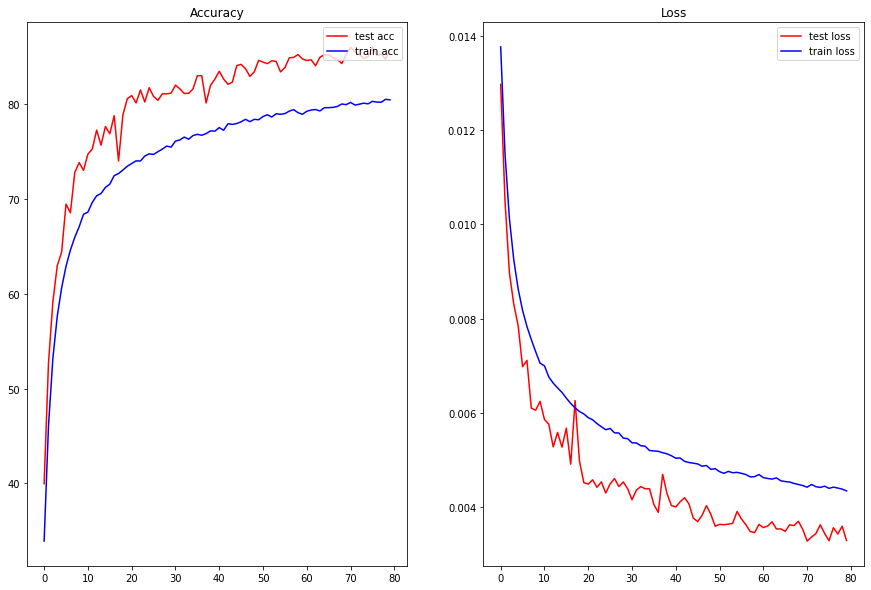

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs =[x for x in range(EPOCHS)]
fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].plot(epochs,test_acc,'-r',label='test acc')
axs[0].plot(epochs,train_acc,'-b',label='train acc')
axs[0].legend(loc="upper right")
axs[0].set_title("Accuracy")

epochs =[x for x in range(EPOCHS)]
axs[1].plot(epochs,test_losses,'r',label='test loss')
axs[1].plot(epochs,train_losses,'b',label='train loss')
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")

# Misclassified Images


********* Misclassified Images **************

Files already downloaded and verified


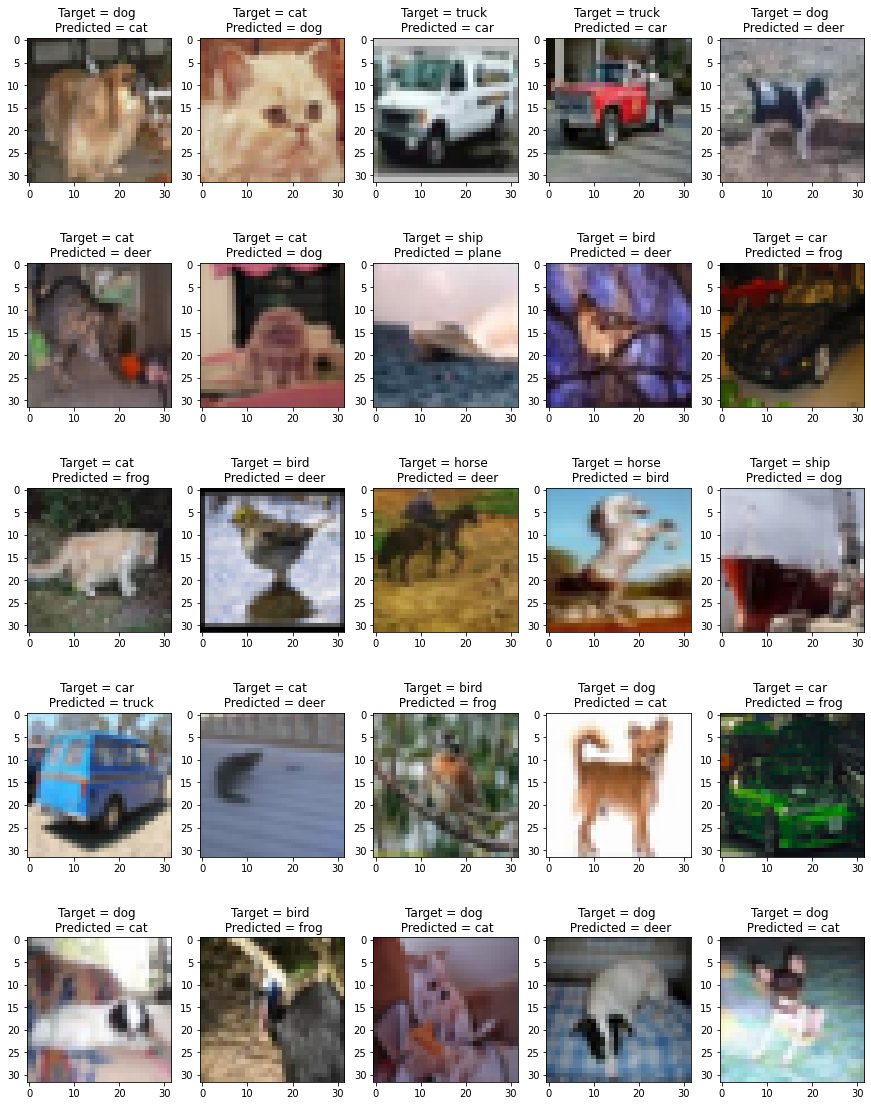

In [14]:
def display_misclassified_images(model):
  print("\n********* Misclassified Images **************\n")
  model.eval()

  # Create a test loader with batch size equal to test data length
  test = Cifar10SearchDataset(root='./data', train=False,
                              download=True, transform=test_transform)
  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=len(test), num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=len(test))
  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          # Get the indexes of images that are incorrectly classified
          indexes = (pred.view(-1,) != target.view(-1,)).nonzero()
          
          fig = plt.figure(figsize=(15, 20))
          for i, idx in enumerate(indexes[:25]):
              ax = fig.add_subplot(5, 5, i+1)
              denorm_images = denormalize(data.cpu(), mean, std)
              ax.imshow(denorm_images[idx].squeeze().permute(1, 2, 0).clamp(0,1))
              ax.set_title(f"Target = {classes[target[idx].item()]} \n Predicted = {classes[pred[idx].item()]}")
          
          plt.show()

display_misclassified_images(model)